# Preliminaries: Image Processing

Graph Neural Networks are a type of neural network for graph data. node2vec and deepwalk stem from the idea of language modeling.
In this module, we will focus on another branch of graph neural networks that stem from image processing.

## Edge Detection Problem in Image Processing

Edge detection is a classical problem in image processing. The goal is to identify the boundaries of objects in an image.

![](https://media.geeksforgeeks.org/wp-content/uploads/20240616211411/Screenshot-(85).webp)

To approach the problem, let us first remind that an image is a matrix of pixels. Each pixel has RGB values, each of which represents the intensity of red, green, and blue color. To simplify the problem, we focus on grayscale images, in which each pixel has only one value representing the brightness. In this case, an image can be represented as a 2D matrix, where each element in the matrix represents the brightness of a pixel.

![](https://ai.stanford.edu/~syyeung/cvweb/Pictures1/imagematrix.png)

### An example

Human eyes are very sensitive to brightness changes. An edge in an image appears when there is a *significant brightness change between adjacent pixels*. To be more concrete, let's consider a small example consisting of 6x6 pixels, with a vertical line from the top to the bottom, where the brightness is higher than the neighboring pixels. This is an edge we want to detect.

$$
X = \begin{bmatrix}
10 & 10 & 80 & 10 & 10 & 10 \\
10 & 10 & 80 & 10 & 10 & 10 \\
10 & 10 & 80 & 10 & 10 & 10 \\
10 & 10 & 80 & 10 & 10 & 10 \\
10 & 10 & 80 & 10 & 10 & 10 \\
10 & 10 & 80 & 10 & 10 & 10
\end{bmatrix}
$$

Let's zoom on the pixel at (3, 3) and its surrounding pixels.

$$
Z = \begin{bmatrix}
10 & 80 & 10 \\
\textcolor{blue}{10} & \textcolor{red}{80} & \textcolor{purple}{10} \\
10 & 80 & 10
\end{bmatrix}
$$

where the central pixel is highlighted in red. Since we are interested in the edge which is a sudden change in brightness along the horizontal direction, we take a derivative at the central pixel by

$$
\nabla Z_{22} = \textcolor{blue}{Z_{2,1}} - \textcolor{purple}{Z_{2,3}}
$$

Following the same process, we can compute the derivative at all pixels, which gives us the (horizontal) derivative of the image.

$$
\begin{bmatrix}
- & -70 & 0 & 70 & 0 & - \\
- & -70 & 0 & 70 & 0 & - \\
- & -70 & 0 & 70 & 0 & - \\
- & -70 & 0 & 70 & 0 & - \\
- & -70 & 0 & 70 & 0 & -
\end{bmatrix}
$$

The symbol `-` indicates that the derivative is not defined because one of the neighboring pixels is out of the image boundary.
We observe that the derivative is high at the edge and low elsewhere. This is a simple but effective way to detect edges in an image.

We can consider a derivative operator along the vertical direction that computes the difference between the vertical neighboring pixels.

$$
\nabla Z_{22} = Z_{1,2} - Z_{3,2}
$$

And, when applied to the entire image, the result is

$$
\begin{bmatrix}
- & - & - & - & -  & - \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
- & - & - & - & - & -
\end{bmatrix}
$$

The all entries are zero, meaning that there is no edge in the vertical direction.

We can combine the horizontal and vertical derivatives to get the gradient of the image. For example,

$$
\nabla Z_{22} = Z_{12} - Z_{32} + Z_{21} - Z_{23}
$$

When applied to the entire image, the result is the same as the horizontal derivative.

### Convolution

We observe that there is a repeated pattern in the derivative computation: we are taking addition and subtraction of neighbiring pixels. This motivates us to generalize the operation to a more general form.

$$
\nabla Z_{22} = \sum_{i=-1}^1 \sum_{j=-1}^1 K_{h-(i+1),w-(j+1)} Z_{2+i, 2+j}
$$

where $K$ is a $3 \times 3$ matrix, and $w=h=3$ represent the width and height of the kernel.

$$
K = \begin{bmatrix}
K_{11} & K_{12} & K_{13} \\
K_{21} & K_{22} & K_{23} \\
K_{31} & K_{32} & K_{33}
\end{bmatrix}
$$

The matrix $K$ is called a **kernel**, and applying it to the image is called **convolution**.

```{note}
The index of the kernel is conventionally reversed. Namely, we reorder the entries of the kernel such that

$$
\begin{bmatrix}
K_{33} & K_{32} & K_{31} \\
K_{23} & K_{22} & K_{21} \\
K_{13} & K_{12} & K_{11}
\end{bmatrix}
$$

Then, take the element-wise product with $Z$

$$
\begin{bmatrix}
Z_{11} K_{33} & Z_{12} K_{32} & Z_{13} K_{31} \\
Z_{21} K_{23} & Z_{22} K_{22} & Z_{23} K_{21} \\
Z_{31} K_{13} & Z_{32} K_{12} & Z_{33} K_{11}
\end{bmatrix}
$$

and sum up all the elements to get the new pixel value $\nabla Z_{22}$.
Why do we reverse the kernel? This is to match with the mathematical definition of convolution, which will be introduced later.
```

```{tip}
In the previous example, we used a $3 \times 3$ kernels called the Prewitt operator, which in terms of $K$ is

$$
K_h = \begin{bmatrix}
-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1
\end{bmatrix}
\quad \text{or} \quad
K_v = \begin{bmatrix}
-1 & -1 & -1 \\
0 & 0 & 0 \\
1 & 1 & 1
\end{bmatrix}
$$

where $K_h$ is the horizontal Prewitt operator and $K_v$ is the vertical Prewitt operator.
```

A kernel represents a local pattern we want to detect. The new pixel value after the convolution is maximized when the pattern is most similar to the kernel in terms of the inner product. This can be confirmed by:

$$
\nabla Z_{22} = \sum_{i=-1}^1 \sum_{j=-1}^1 K_{h-(i+1),w-(j+1)} Z_{2+i, 2+j} = \langle \hat K, Z \rangle
$$

where $\langle \cdot, \cdot \rangle$ is the inner product, and $\hat K$ is the order-reversed kernel.

```{note}
Check out this awesome interactive demo to see how different kernels work: [Demo](https://setosa.io/ev/image-kernels/)
```

## Fourier Transform

![](https://miro.medium.com/v2/resize:fit:1400/1*D6iRfzDkz-sEzyjYoVZ73w.gif)

Convolution computes the new pixel values by sliding a kernel over an image. How is the resulting image related to the original image?



To answer this question, let us consider a row of an image and convolve it with a kernel $K$.

$$
\begin{aligned}
X &= \begin{bmatrix}
X_1 & X_2 & X_3 & X_4 & X_5 & X_6
\end{bmatrix} \\
K &= \begin{bmatrix}
K_1 & K_2 & K_3
\end{bmatrix}
\end{aligned}
$$

The convolution of $X$ and $K$ is

$$
X * K = \begin{bmatrix}
X_1 K_3 + X_2 K_2 + X_3 K_1 & X_2 K_3 + X_3 K_2 + X_4 K_1 & X_3 K_3 + X_4 K_2 + X_5 K_1 & X_4 K_3 + X_5 K_2 + X_6 K_1
\end{bmatrix}
$$

...which is complicated, right? 😅 So let's make it simple by using a useful theorem called **the convolution theorem**.

The convolution theorem gives us a simpler way to think about convolution. Instead of doing the complex sliding window operation in the original domain (like pixel values), we can:

1. Transform both signals to the frequency domain using Fourier transform
2. Multiply them together (much simpler!)
3. Transform back to get the same result

Mathematically, the above steps can be written as:

1. $\mathcal{F}(X), \mathcal{F}(K)$ - Transform both signals to frequency domain (Fourier transform)
2. $\mathcal{F}(X) \cdot \mathcal{F}(K)$ - Multiply the transformed signals
3. $\mathcal{F}^{-1}(\mathcal{F}(X) \cdot \mathcal{F}(K))$ - Transform back to get $X * K$

where $\mathcal{F}^{-1}$ is the inverse Fourier transform that brings us back to the original domain. This is much easier than computing the convolution directly!

For a discrete signal $x[n]$ with $N$ points, the Fourier transform $\mathcal{F}$ is defined as:

$$
\mathcal{F}(x)[k] = \sum_{n=0}^{N-1} x[n] \cdot e^{-2\pi i \frac{nk}{N}}
$$

where $i$ is the imaginary unit. Or equivalently,

$$
\mathcal{F}(x)[k] = \sum_{n=0}^{N-1} x[n] \cdot \left[ \cos\left(2\pi \frac{nk}{N}\right) - i \sin\left(2\pi \frac{nk}{N}\right) \right]
$$

using Euler's formula $e^{ix} = \cos(x) + i\sin(x)$.

```{note}
Complex number can be thought of as a way to represent a 2D vector using a single value (which is a computer science perspective; mathematically, it is a bit more subtle). For example, $e^{i\pi/2} = \cos(\pi/2) + i\sin(\pi/2)$ represents the 2D vector $(\cos(\pi/2), \sin(\pi/2))$. In the context of Fourier transform, we interpret $e^{-2\pi i \frac{nk}{N}}$ as two *base waves*, i.e., sine and cosine, with phase $\frac{2\pi k}{N}$.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/7/71/Euler%27s_formula.svg/360px-Euler%27s_formula.svg.png)
```

In simple terms, $\mathcal{F}$ takes a signal (like our row of pixel values) and breaks it down into sine and cosine waves of different frequencies. Each frequency component $k$ tells us "how much" of that frequency exists in our original signal.
Don't worry too much about the complex math. The key idea is that $\mathcal{F}$ represents a signal as a sum of multiple waves with different frequencies, so we can understand the signal in terms of its frequencies rather than its original values.


![](https://devincody.github.io/Blog/post/an_intuitive_interpretation_of_the_fourier_transform/img/FFT-Time-Frequency-View_hu24c1c8fe894ecd0dad24174b2bed08c9_99850_800x0_resize_lanczos_2.png)


```{note}
3Blue1Brown makes a beautiful video explaining Fourier transform: [Video](https://www.youtube.com/watch?v=spUNpyF58BY). Here is a great interactive demo on Fourier transform by Jez Swanson: [Demo](https://www.jezzamon.com/fourier/).
```

### An example for the Fourier transform

Now, let's perform the convolution using the Fourier transform using an example.

In [1]:
import numpy as np
X = np.array([10, 10, 80, 10, 10, 10])
K = np.array([-1, 0, 1])

Let us first perform the convolution directly.

In [2]:
# Pad X with zeros on both sides to handle boundary
n_conv = len(X) - len(K) + 1  # Now we get full length output
XKconv = np.zeros(n_conv)

for i in range(n_conv):
    XKconv[i] = np.sum(X[i:(i+len(K))] * K[::-1]) # Reverse the kernel and take element-wise product and sum up
XKconv

array([-70.,   0.,  70.,   0.])

Let us now perform the convolution using the Fourier transform. We compute the Fourier transform of $X$ and $K$.

In [3]:
# Step 1: Transform X and K to frequency domain
FX = np.fft.fft(X)
# Pad K with zeros to match the length of X before FFT
K_padded = np.pad(K, (0, len(X) - len(K)), 'constant') # [-1  0  1  0  0  0]
FK = np.fft.fft(K_padded)
print("FX:", FX)

FX: [130.+0.00000000e+00j -35.-6.06217783e+01j -35.+6.06217783e+01j
  70.+7.10542736e-15j -35.-6.06217783e+01j -35.+6.06217783e+01j]


- We add zeros to $K$ to make it the same length as $X$ before applying the Fourier transform. This is necessary because the convolution theorem requires the signals to have the same length.
- `FX` is the Fourier transform of $X$, which is a complex number. Each entry $FX[k]$ represents the weight of the cosine wave in its real part and the weight of the sine wave in its imaginary part, with phase $2\pi k / N$. Similarly for `FK`.

Next, we multiply the transformed signals.

In [4]:
FXKconv = FX * FK

This is the convolution in the frequency domain. Finally, we transform back to get the convolution.

In [5]:
XKconv_ft = np.real(np.fft.ifft(FXKconv))
XKconv_ft

array([ 2.84957243e-15,  3.05036092e-15, -7.00000000e+01,  1.88737914e-15,
        7.00000000e+01, -1.05195948e-15])

- We take the real part. The imaginary part is due to numerical artifacts that do not matter in practice.
- The Fourier transform convolution produces a longer output than direct convolution because it includes partial overlaps between K and X at the boundaries. Since we only want the full overlaps, we need to truncate the first two elements of `XKconv_ft` (as K has length 3) to match the length of the direct convolution result.
- For example, let's look at what happens at the beginning of the convolution:
  - At position -2: Only the last element of K overlaps with X: `[0, 0, 10] * [-1, 0, 1] = 10`
  - At position -1: Two elements of K overlap with X: `[0, 10, 10] * [-1, 0, 1] = 10`
  - At position 0: Full overlap begins: `[10, 10, 80] * [-1, 0, 1] = 70`

  The Fourier transform method gives us all these positions (-2, -1, 0, ...), but we only want the full overlaps starting from position 0, which is why we truncate the first two elements.

In [6]:
XKconv_ft = XKconv_ft[2:]
XKconv_ft

array([-7.00000000e+01,  1.88737914e-15,  7.00000000e+01, -1.05195948e-15])

This gives us the same result as the direct convolution up to numerical errors.

## Fourier Transform of Images

Let's extend the above example to an image which is a 2D matrix.
The idea is the same: we take the Fourier transform of each row and column of the image, and then multiply them together to get the convolution in the frequency domain.
More specifically, for an image $X$ with size $H \times W$, the Fourier transform of $X$ is

$$
\begin{aligned}
\mathcal{F}(X)[h, w] &= \sum_{k=0}^{H-1} \sum_{\ell=0}^{W-1} X[k, \ell] \cdot e^{-2\pi i \frac{hk}{H}} \cdot e^{-2\pi i \frac{w\ell}{W}} \\
&= \sum_{k=0}^{H-1} \sum_{\ell=0}^{W-1} X[k, \ell] e^{-2\pi i \left(\frac{hk}{H} + \frac{w\ell}{W}\right)}
\end{aligned}
$$

Comparing with the 1D case, we see that the 2D Fourier transform is *functionally* the same as the 1D Fourier transform, except that we now have two indices $h$ and $w$ to represent the frequency in both dimensions.
The basis waves are 2D waves as shown below.

**Cosine waves**

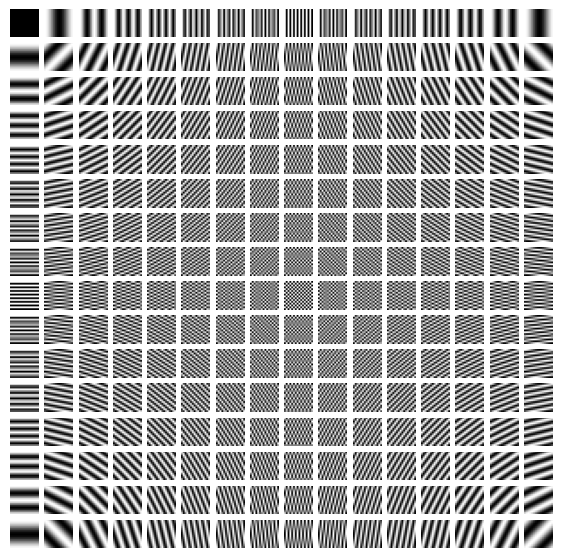

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def basis_function(img_size=256, u=0, v=0):
  '''
  img_size : square size of image f(x,y)
  u,v : spatial space indice
  '''
  N = img_size
  x = np.linspace(0, N-1, N)
  y = np.linspace(0, N-1, N)
  x_, y_ = np.meshgrid(x, y)
  bf = np.exp(-1j*2*np.pi*(u*x_/N+v*y_/N))
  if u == 0 and v == 0:
    bf = np.round(bf)
  real = np.real(bf) # The cosine part
  imag = np.imag(bf) # The sine part
  return real, imag

size = 16
bf_arr_real = np.zeros((size*size,size,size))
bf_arr_imag = np.zeros((size*size,size,size))
ind = 0
for col in range(size):
  for row in range(size):
    re,imag = basis_function(img_size=size, u=row, v=col)
    bf_arr_real[ind] = re
    bf_arr_imag[ind] = imag
    ind += 1

# real part
_, axs = plt.subplots(size, size, figsize=(7, 7))
axs = axs.flatten()
for img, ax in zip(bf_arr_real, axs):
  ax.set_axis_off()
  ax.imshow(img,cmap='gray')

**Sine waves**

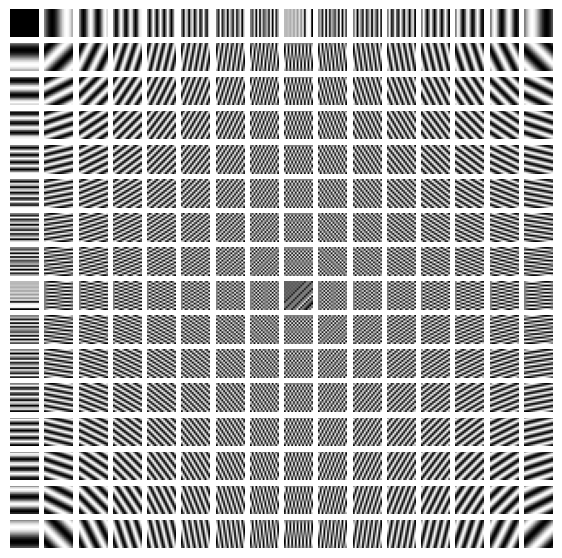

In [8]:
# imaginary part
_, axs = plt.subplots(size, size, figsize=(7, 7))
axs = axs.flatten()
for img, ax in zip(bf_arr_imag, axs):
  ax.set_axis_off()
  ax.imshow(img,cmap='gray')

The Fourier transform of an image is a decomposition of an image into the sum of these basis waves.

### An example of Fourier transform

Let us apply the Fourier transform to an image.

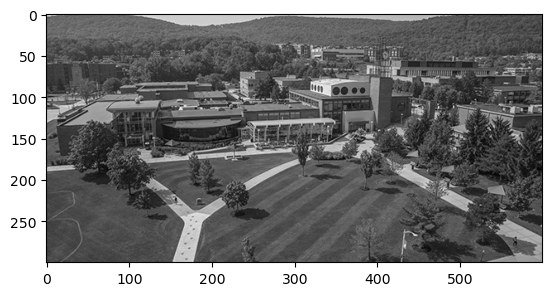

In [9]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

# Read image from URL
def read_jpeg_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # Convert to RGB mode if needed (in case it's RGBA)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img

def image_to_numpy(img):
    return np.array(img)

def to_gray_scale(img_np):
    return np.mean(img_np, axis=2)

# URL of the image
url = "https://www.binghamton.edu/news/images/uploads/features/20180815_peacequad02_jwc.jpg"

img = read_jpeg_from_url(url)
img_np = image_to_numpy(img)
img_gray = to_gray_scale(img_np)

plt.imshow(img_gray, cmap='gray')

Take the Fourier transform of the image.

In [10]:
ft_img_gray = np.fft.fft2(img_gray)

This decomposes the image into a sum of basis waves. Let's see the weights of the basis waves.

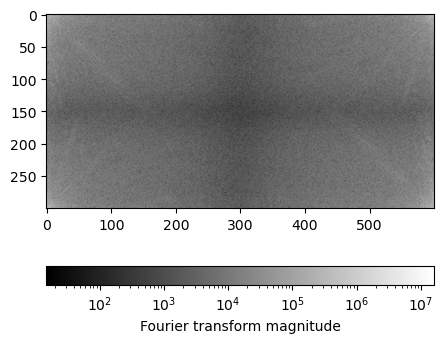

In [11]:
import matplotlib

weight = np.abs(ft_img_gray)

# real part
fig1, ax1 = plt.subplots(figsize=(5, 5))

ax1.imshow(weight, cmap='gray', norm=matplotlib.colors.LogNorm(), aspect='equal')
cbar = fig1.colorbar(ax1.images[0], ax=ax1, orientation='horizontal')
cbar.set_label('Fourier transform magnitude')

The corresponding basis waves look like this:

Text(0.5, 0.98, 'Imaginary Part of Basis Functions')

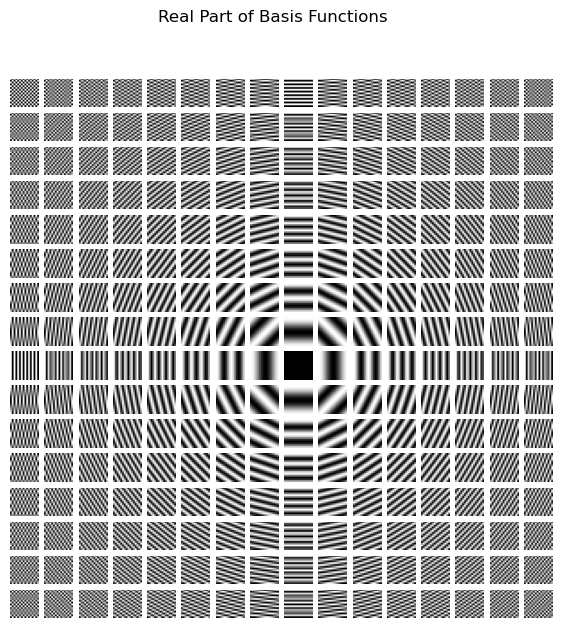

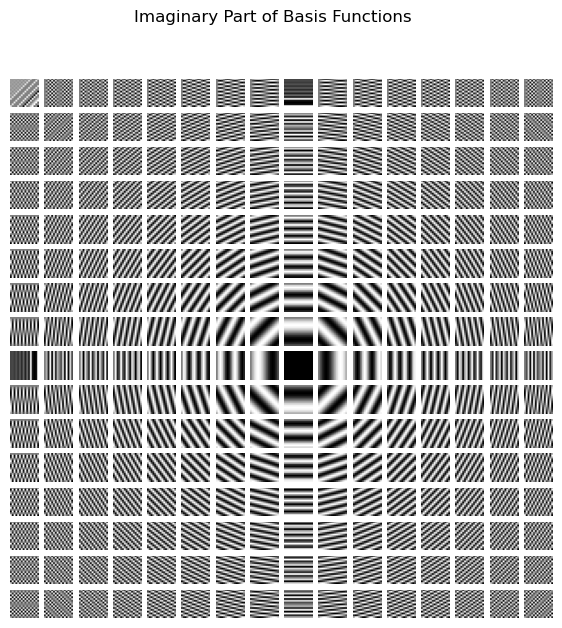

In [12]:
size = 16
bf_arr_real = np.zeros((size*size,size,size))
bf_arr_imag = np.zeros((size*size,size,size))
ind = 0
for col in range(-size//2, size//2):
  for row in range(-size//2, size//2):
    re,imag = basis_function(img_size=size, u=row, v=col)
    bf_arr_real[ind] = re
    bf_arr_imag[ind] = imag
    ind += 1

# real part
fig, axs = plt.subplots(size, size, figsize=(7, 7))
axs = axs.flatten()
for img, ax in zip(bf_arr_real, axs):
  ax.set_axis_off()
  ax.imshow(img,cmap='gray')

fig.suptitle('Real Part of Basis Functions')


# imaginary part
fig, axs = plt.subplots(size, size, figsize=(7, 7))
axs = axs.flatten()
for img, ax in zip(bf_arr_imag, axs):
  ax.set_axis_off()
  ax.imshow(img,cmap='gray')

fig.suptitle('Imaginary Part of Basis Functions')

Now, let's see the convolution of the image with a Prewitt operator.

In [13]:
K = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]) # Prewitt operator

K_padd = np.zeros((img_gray.shape[0], img_gray.shape[1]))
K_padd[:K.shape[0], :K.shape[1]] = K

# convolution
FK = np.fft.fft2(K_padd)

The Fourier transform of the Prewitt operator looks like this:

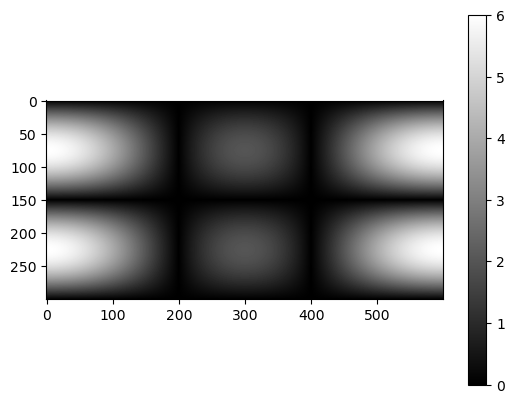

In [14]:
plt.imshow(np.abs(FK), cmap='gray')
cbar = plt.colorbar()

We can think of the frequency domain of the kernel as a **filter** that suppresses some frequencies and allows others to pass through. In the example of the Prewitt operator, the kernel `FK` has a low value around the center of the image. The product $FX \cdot FK$ then suppresses the low-frequency components of the image, and we are left with the high-frequency components that correspond to the horizontal edges. We can think of this as a high-pass filter that only allows high-frequency components to pass through.

Let's see the convolution result.

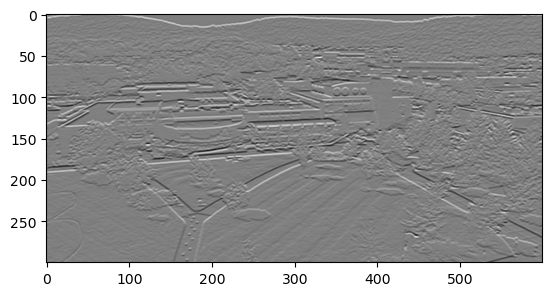

In [15]:
FX = np.fft.fft2(img_gray)
conv_img_gray = np.real(np.fft.ifft2(FX * FK))
plt.imshow(conv_img_gray, cmap='gray')

We observe that the horizontal edges are highlighted.

```{note}
A widespread application of the 2D Fourier transform is JPEG format. Here's how it works:

(1) It first breaks the image into small 8x8 squares.
(2) It converts each square into frequencies using the Discrete Cosine Transform. The sine part is discarded for compression.
(3) It keeps the important low frequencies that our eyes can see well.
(4) It throws away most of the high frequencies that our eyes don't notice much.

These steps make the file much smaller while still looking good to us.
```



## A key lesson from image processing

We have seen an equivalence between convolution in the pixel (spatial) domain and multiplication in the frequency domain.
Using the Fourier transform, an image is decomposed into a sum of basis waves.
The *kernel* can be thought of as *a filter* that suppresses some basis waves and allows others to pass through.